### Add libraries

In [1]:
import tensorflow as tf 
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
import os 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
import seaborn as sns

### Path system

In [3]:
# you need the current working directory NB: works both windows and linux 
current_working_directory = os.getcwd()
current_working_directory = os.path.dirname(current_working_directory)

# get the directory where I want to download the dataset
path_of_download = os.path.join(*['..', current_working_directory, 'Assignment2', 'weather_dataset'])
print(f"[DIR] The directory of the current dataset is {path_of_download}")

[DIR] The directory of the current dataset is C:\Users\ayesh\Documents\UTU\CV_SF\Assignment2\weather_dataset


### function for data loading 

In [6]:
# here let s do some functions that we can re-use also for other assignment
def load_the_data_and_the_labels(data_set_path: str, target_size: tuple or None = None):
    try:
        dataset, labels, name_of_the_labels = list(), list(), list() 
        # let s loop here and we try to discover how many class we have 
        for class_number, class_name in enumerate(os.listdir(data_set_path)):
            full_path_the_data = os.path.join(data_set_path, class_name)
            print(f"[WALK] I am walking into {full_path_the_data}")
            
            # add the list to nam _list
            name_of_the_labels.append(class_name)
            
            for single_image in os.listdir(f"{full_path_the_data}"):
                full_path_to_image = os.path.join(*[full_path_the_data, single_image])
                
                # add the class number 
                labels.append(class_number)
                
                if target_size is None:
                    # let s load the image 
                    image = tf.keras.utils.load_img(full_path_to_image)
                else:
                    image = tf.keras.utils.load_img(full_path_to_image, target_size=target_size)
                
                # transform PIL object in image                    
                image = tf.keras.utils.img_to_array(image)
                
                # add the image to the ds list 
                dataset.append(image)
                
        return np.array(dataset, dtype='uint8'), np.array(labels, dtype='int'), name_of_the_labels
    except Exception as ex:
        print(f"[EXCEPTION] load the data and the labels throws exceptions {ex}")

### OHE function

In [8]:
# here we have to one hot encode the labes
def make_the_one_hot_encoding(labels_to_transform):
    try:
        enc = OneHotEncoder(handle_unknown='ignore')
        # this is a trick to figure the array as 2d array instead of list 
        temp = np.reshape(labels_to_transform, (-1, 1))
        labels_to_transform = enc.fit_transform(temp).toarray()
        print(f'[ONE HOT ENCODING] Labels are one-hot-encoded: {(labels_to_transform.sum(axis=1) - np.ones(labels_to_transform.shape[0])).sum() == 0}')
        return labels_to_transform
    except Exception as ex:
        print(f"[EXCEPTION] Make the one hot encoding throws exception {ex}")

### Function to visualize predictions ###

In [ ]:
def visualize_predictions(model, X_test, y_test, label_names, num_images=5):
    # Randomly select 'num_images' images from the test set
    indices = np.random.randint(0, len(X_test), num_images)

    # Create subplots to visualize the predictions
    plt.figure(figsize=(12, 8))

    for i, idx in enumerate(indices):
        # Get the image and true label
        image = X_test[idx]
        true_label = np.argmax(y_test[idx])  # True label (one-hot encoded)
        
        # Rescale the image if necessary (if it's normalized between 0 and 1)
        image_rescaled = np.clip(image * 255, 0, 255).astype('uint8')

        # Make the prediction
        prediction = model.predict(np.expand_dims(image, axis=0))  # Add batch dimension
        predicted_label = np.argmax(prediction)  # Predicted label

        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_rescaled)
        plt.axis('off')  # Hide the axes
        plt.title(f"True: {label_names[true_label]}\nPred: {label_names[predicted_label]}")

    plt.show()

### load the data and labels 

In [10]:
# target size for the the images.
target_size= (224, 224, 3)

# load the train dataset from the path
dataset, labels, label_names = load_the_data_and_the_labels(path_of_download, target_size)

[WALK] I am walking into C:\Users\ayesh\Documents\UTU\CV_SF\Assignment2\weather_dataset\Cloudy
[WALK] I am walking into C:\Users\ayesh\Documents\UTU\CV_SF\Assignment2\weather_dataset\Rain
[WALK] I am walking into C:\Users\ayesh\Documents\UTU\CV_SF\Assignment2\weather_dataset\Shine
[WALK] I am walking into C:\Users\ayesh\Documents\UTU\CV_SF\Assignment2\weather_dataset\Sunrise


In [11]:
print("Dataset shape: ", dataset.shape)  
print("Labels shape: ", labels.shape)  
print("Label names: ", label_names) 

Dataset shape:  (1125, 224, 224, 3)
Labels shape:  (1125,)
Label names:  ['Cloudy', 'Rain', 'Shine', 'Sunrise']


### one hot encoding to the labels

In [14]:
# Fit and transform the labels
one_hot_labels = make_the_one_hot_encoding(labels_to_transform=labels)

print("Original Labels:", labels.flatten())
print("One-Hot Encoded Labels:\n", one_hot_labels)


[ONE HOT ENCODING] Labels are one-hot-encoded: True
Original Labels: [0 0 0 ... 3 3 3]
One-Hot Encoded Labels:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


### split the dataset in train and test set (ratio 0.3)

In [16]:
# Split dataset and labels into 70% training and 30% testing
# stratify=one_hot_labels , Ensures that the train and test sets maintain the same class distribution as the original dataset.
# one_hot_labels (y variables) - These are the labels corresponding to the images, encoded using One-Hot Encoding. 
# Instead of categorical values (0, 1, 2, 3), the labels are converted into binary vectors.

X_train, X_test, y_train, y_test = train_test_split(dataset, one_hot_labels, test_size=0.3, random_state=42, stratify=one_hot_labels)

# Print shapes of the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (787, 224, 224, 3) (787, 4)
Testing set shape: (338, 224, 224, 3) (338, 4)


- X_train.shape: (787, 224, 224, 3) - 787 training images, each of size 224 × 224 with 3 color channels (RGB).
- y_train.shape: (787, 4) - 787 corresponding one-hot encoded labels, each having 4 values (one for each class).
- X_test.shape: (338, 224, 224, 3) - 338 test images, same dimensions as training images.
- y_test.shape: (338, 4) - 338 one-hot encoded labels for test images.

### normalize the data

In [18]:
# Normalize the training set
X_train = X_train / 255.0
X_test = X_test / 255.0

In [20]:

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (787, 224, 224, 3) (787, 4)
Testing set shape: (338, 224, 224, 3) (338, 4)


### create the CNN and set all parameters to trainable
a.	Input layer
b.	As base model use VGG19:
    i.	Weights: imagenet
    ii.	Include_top: False
    iii.	Input_shape the target shape described in point 1. 
c.	Add a flatten layer 
d.	Add a Dense layer with 512 units and a dropout layer with 0.1 unit.
e.	Add a Dense layer with 256 units and a dropout layer with 0.1 unit.
f.	Add the final classifier with the correct number of units and the suitable activation.


- Input Layer: Defines the expected input shape (224, 224, 3), which matches the target image size.

- VGG19 as Base Model:

  weights="imagenet" → Uses pre-trained weights from ImageNet.
  include_top=False → Removes the default classification layers so we can add our own.
  input_shape=target_size → Sets our custom input shape.

- Flatten Layer: Converts the VGG19 output feature maps into a 1D vector for classification.

- Dense layer 1:
  Dense(512, activation="relu") → Adds 512 neurons with ReLU activation.
  Dropout(0.1) → Drops 10% of neurons to prevent overfitting.

- Dense layer 2:
  Dense(256, activation="relu") → Adds another dense layer with 256 neurons.
  Dropout(0.1) → Another 10% dropout for regularization.

- Final Classifier Layer:
  Dense(4, activation="softmax") →
  4 neurons for 4 classes (cloudy, rain, shine, sunrise).
  Softmax activation outputs probabilities for each class.


In [22]:
# Load pre-trained VGG19 model without the top classification layers
baseModel = VGG19(input_shape=target_size, weights='imagenet', include_top=False) # Input model use VGG19 use imagenet weight

# Enable training on all layers (fine-tuning the pre-trained model)
for layer_ctn, layer in enumerate(baseModel.layers[:]):
    layer.trainable = True
    
# Flatten layer to convert feature maps into a vector
x = Flatten()(baseModel.output)

# Fully connected layer with 512 neurons and dropout
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x)

# Fully connected layer with 256 neurons and dropout
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)

# Output layer with 4 neurons (one for each class) and softmax activation
x = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=baseModel.input, outputs=x)

# Print mode summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,002,308 (125.89 MB)

 Trainable params: 33,002,308 (125.89 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Verify if layers are trainable

for layer_ctn, layer in enumerate(baseModel.layers[:]):
    print(layer.name, "Trainable:", layer.trainable)


input_layer Trainable: True
block1_conv1 Trainable: True
block1_conv2 Trainable: True
block1_pool Trainable: True
block2_conv1 Trainable: True
block2_conv2 Trainable: True
block2_pool Trainable: True
block3_conv1 Trainable: True
block3_conv2 Trainable: True
block3_conv3 Trainable: True
block3_conv4 Trainable: True
block3_pool Trainable: True
block4_conv1 Trainable: True
block4_conv2 Trainable: True
block4_conv3 Trainable: True
block4_conv4 Trainable: True
block4_pool Trainable: True
block5_conv1 Trainable: True
block5_conv2 Trainable: True
block5_conv3 Trainable: True
block5_conv4 Trainable: True
block5_pool Trainable: True


### compile the model with adam

In [26]:

model.compile(optimizer='adam',
              loss=tf.keras.metrics.categorical_crossentropy,
              metrics=["accuracy"])

### Fit the model with batch size 32 and 15 epochs (This take 15 - 20 minutes with the CPU)

In [28]:

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    epochs=15,
                    verbose=1)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 384s 15s/step - accuracy: 0.2602 - loss: 6.5655 - val_accuracy: 0.3166 - val_loss: 1.3740
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 378s 15s/step - accuracy: 0.2868 - loss: 1.3860 - val_accuracy: 0.3166 - val_loss: 1.3752
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 374s 15s/step - accuracy: 0.3012 - loss: 1.3677 - val_accuracy: 0.3166 - val_loss: 1.3785
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 382s 15s/step - accuracy: 0.3275 - loss: 1.3773 - val_accuracy: 0.3166 - val_loss: 1.3721
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 383s 15s/step - accuracy: 0.3293 - loss: 1.3681 - val_accuracy: 0.3166 - val_loss: 1.3695
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 383s 15s/step - accuracy: 0.3180 - loss: 1.3708 - val_accuracy: 0.3166 - val_loss: 1.3691
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 400s 16s/step - accuracy: 0.3242 - loss: 1.3718 - val_accuracy: 0.3166 - val_loss: 1.3691
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 367s 15s/step - accuracy: 0.2800 - loss: 1.3776 - val_accuracy: 0.

### Evaluate  the model 

In [30]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)

11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3078 - loss: 1.3728


In [32]:
# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 31.66%


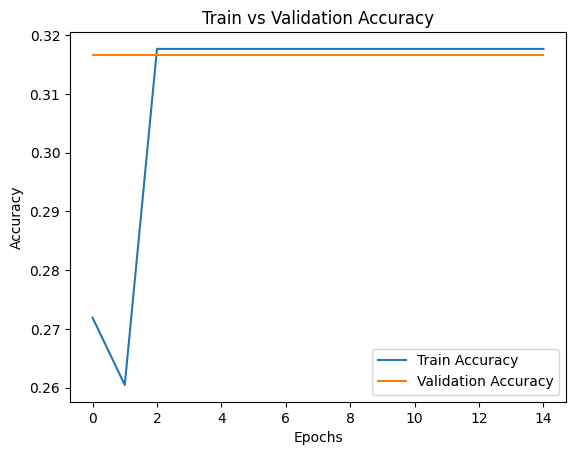

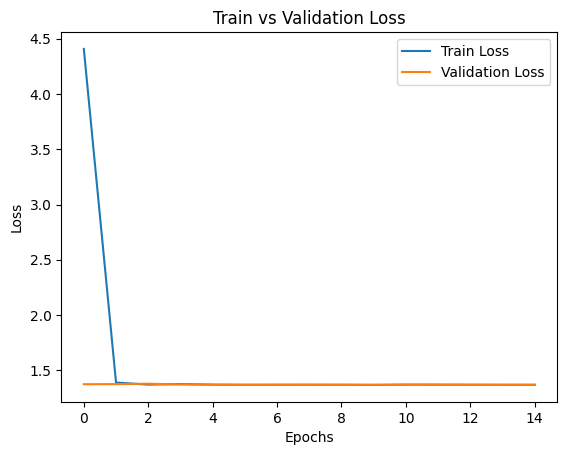

In [34]:
# Plot accuracy graph
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')
plt.show()

# Plot loss graph
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()

#### Make and show predictions 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


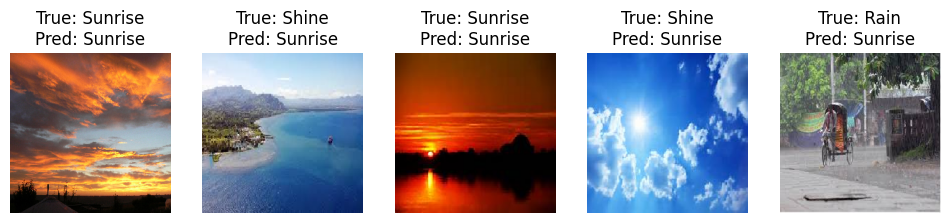

In [47]:
# Visualize some predictions
visualize_predictions(model, X_test, y_test, label_names, num_images=5)


### make confusion matrix 

11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


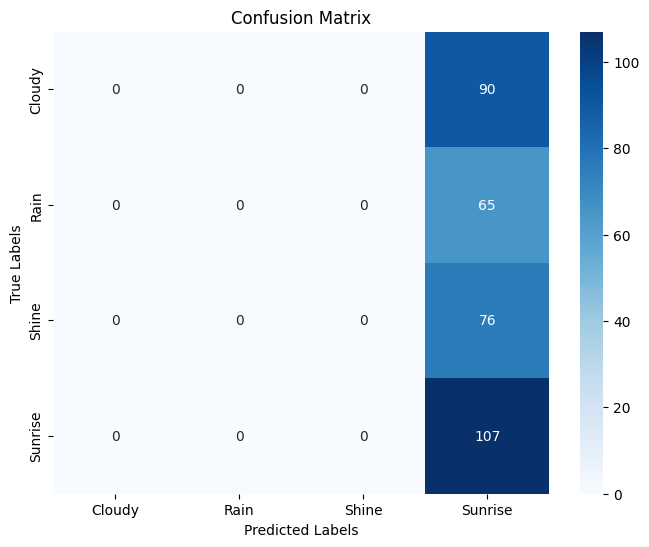

In [49]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels from the predicted probabilities

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Load again the cnn but this time set the parameters to NOT TRAINABLE 

In [93]:
# Reload the model again with not trainable

baseModel = VGG19(input_shape=target_size, weights='imagenet', include_top=False) # Input model use VGG19 use imagenet weight

# Freeze all layers in the base model to retain pre-trained features
for layer_ctn, layer in enumerate(baseModel.layers[:]):
    layer.trainable = False

# Flatten layer to convert feature maps into a vector
x = Flatten()(baseModel.output)

# Fully connected layer with 512 neurons and dropout
x = Dense(512, activation='relu')(x) 
x = Dropout(0.1)(x)

# Fully connected layer with 256 neurons and dropout
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)

# Output layer with 4 neurons (one for each class) and softmax activation
x = Dense(4, activation='softmax')(x)

# Create the final model
model2 = Model(inputs=baseModel.input, outputs=x)

model2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,002,308 (125.89 MB)

 Trainable params: 12,977,924 (49.51 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [95]:
# Verify if layers are trainable

for layer_ctn, layer in enumerate(baseModel.layers[:]):
    print(layer.name, "Trainable:", layer.trainable)


input_layer_4 Trainable: False
block1_conv1 Trainable: False
block1_conv2 Trainable: False
block1_pool Trainable: False
block2_conv1 Trainable: False
block2_conv2 Trainable: False
block2_pool Trainable: False
block3_conv1 Trainable: False
block3_conv2 Trainable: False
block3_conv3 Trainable: False
block3_conv4 Trainable: False
block3_pool Trainable: False
block4_conv1 Trainable: False
block4_conv2 Trainable: False
block4_conv3 Trainable: False
block4_conv4 Trainable: False
block4_pool Trainable: False
block5_conv1 Trainable: False
block5_conv2 Trainable: False
block5_conv3 Trainable: False
block5_conv4 Trainable: False
block5_pool Trainable: False


In [97]:
# Compile the model
model2.compile(optimizer='adam',
              loss=tf.keras.metrics.categorical_crossentropy,
              metrics=["accuracy"])

### Fit the model with batch size 32 and 15 epochs (This is fsaster)

In [99]:
# Train the model with batch size of 32 and 15 epochs
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    epochs=15,
                    verbose=1)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.3491 - loss: 3.9864 - val_accuracy: 0.6686 - val_loss: 0.8229
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.6632 - loss: 0.8471 - val_accuracy: 0.8343 - val_loss: 0.4273
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.8681 - loss: 0.3172 - val_accuracy: 0.8846 - val_loss: 0.2920
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.9385 - loss: 0.1764 - val_accuracy: 0.8550 - val_loss: 0.3626
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.9347 - loss: 0.1747 - val_accuracy: 0.9231 - val_loss: 0.2210
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9605 - loss: 0.1003 - val_accuracy: 0.9112 - val_loss: 0.2372
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9917 - loss: 0.0367 - val_accuracy: 0.9379 - val_loss: 0.2161
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9858 - loss: 0.0605 - val_accuracy: 0.8905 - val_

# Evaluate the model

In [101]:
# Evaluate the model on the test set
test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9382 - loss: 0.2192


In [103]:
# Print the accuracy
print(f"Test Accuracy: {test_accuracy2 * 100:.2f}%")


Test Accuracy: 92.01%


### Make and show some predictions 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


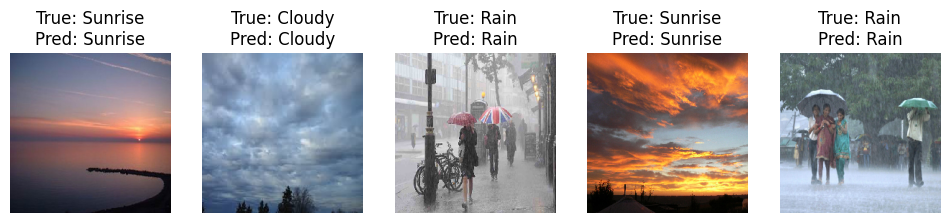

In [81]:

# Visualize some predictions
visualize_predictions(model2, X_test, y_test, label_names, num_images=5)


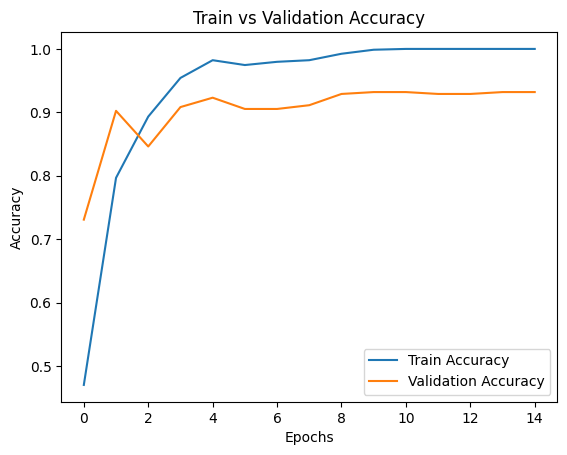

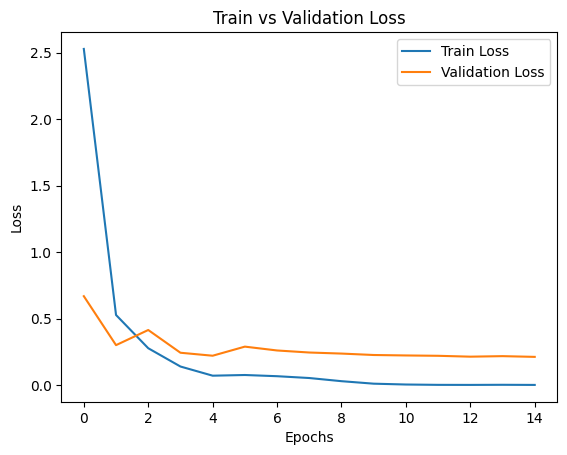

In [77]:
# Plot accuracy graph
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')
plt.show()

# Plot loss graph
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


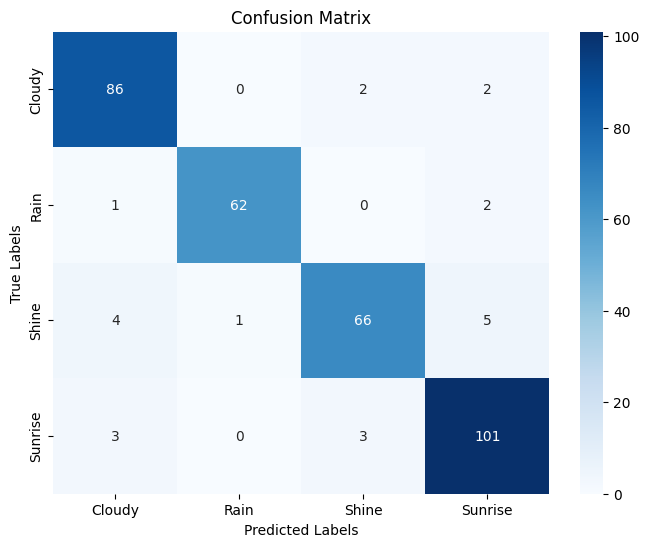

In [79]:
# Make predictions on the test set
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels from the predicted probabilities

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### Observations for trainable=True (fine tuning)
- <b>Training accuracy slightly increases from 26.02% → 33.23%.</b>
- <b>Validation accuracy stays stuck at 31.66% the entire time </b> → no improvement on test data.
- Even though training accuracy increased a bit, the model failed to generalize (a classic sign of overfitting).

So, while accuracy did increase slightly, it wasn't enough to show meaningful learning. Instead, the model was likely just memorizing training patterns without improving generalization.

#### Observations for trainable=False (Feature Extraction)

1. <b> Training Accuracy Improved Significantly</b>
    - Increased from 34.91% → 100% over 15 epochs.
    - The model quickly learned the dataset using the pre-trained VGG19 features.
  
2.  <b>Validation Accuracy Increased as Well</b>
    - Started at 66.86% (Epoch 1) and improved to 92.01% (Epoch 15).
    - This indicates the model was generalizing well to unseen data.
  
3. <b>Validation Accuracy Stayed Close to Training Accuracy</b>
    - Unlike trainable=True, where validation accuracy was stuck at 31.66%, here the validation accuracy followed the training accuracy trend.
    - No signs of severe overfitting, meaning the pre-trained VGG19 features worked well.

#### In summary, ####
- Freezing VGG19 layers (trainable=False) allowed the model to generalize well, leading to a final test accuracy of 92.01%.
- Fine-tuning (trainable=True) resulted in poor generalization, getting stuck at 31.66% test accuracy.

This confirms that, feature extraction (trainable=False) was the best approach.